# Project Update
### 2019-04-19

## Calculating thermal time indices and merging UAV data.

**Name**: Byron Evers<br/>
**Semester**: Spring 2019 <br/>
**Project area**: Agronomy

## Table of contents
1. [Objective](#Update_Objective)
2. [Motivation](#Update_Motivation)
3. [Equations](#Update_Equations)
    * [GDD](#Update_GDD)
    * [Pdays](#Update_Pdays)
    * [BMT](#Update_BMT)
4. [Progress](#Update_Progress)
5. [Road Blocks](#Update_Road_Blocks)
6. [Examples](#Update_examples)
    * [Mesonet Input](#Update_inputs)
    * [Functions](#Update_function)
    * [Graph](#Update_graph)
    * [Data Frame Output](#Update_output)

## Motivation
- Poland labs current UAV pipeline includes stitching photos and extracting plot level reflectance data through Agisoft software.
- Data received from this process is in either an Excel or csv file. 
- The data set includes reflectance values for 5 individual bands (R,G,B,RE and NIR) and 3 vegetative indices (NDVI, NDRE and GNDVI). 
- Thermal time indices are important for data analysis between years
- Comparing thermal time indices maybe useful in plots with diverse germplasm

<a name="Update_Objective"></a>
## Objective

1. Write a python function to calculate three thermal time indices for all UAV collection dates
    * growing degree days (GDD)
    * physiological days (Pdays)
    * biometeorological time (BMT) 
2. Merge all of the UAV reflectance data, plot level phenotypic data and the calculated thermal values into one .csv file.

**I would like to emphasize that the goal of this project is to create a single output file with UAV data and thermal time indices. Calculating UAV indices such as NDVI is already completed by this point. The diagram bellow shows the outline of the entire process. However only steps in green are the objectives of this project.**

<img src="diagram.png" alt="sketch_image" width="1000"/>

<a name="Update_Equations"></a>
## Equations

<a name="Update_GDD"></a>
### Growing Degree Days (GDD):
$$GDD = \sum_{Planting}^{Harvest}(\frac{Tmax+Tmin}{2})-Tbase$$

<a name="Update_Pdays"></a>
### Physiological Days (Pdays):
$$Pdays = \frac{1}{24}(5*P(T_1)+8*P(T_2)+8*P(T_3)+3*P(T_4))$$
**Where**
* $T_1=Tmin$
* $T_2=\frac{(2*Tmin)+Tmax}{3}$
* $T_3=\frac{Tmin+(2*Tmax)}{3}$
* $T_4=Tmax$

**And P is**
* $P=0$   When $T <=Tmin$
* $P=k*(1-\frac{(T-Topt)2}{(Topt-Tmin)2})$ when $Tmin <= T <=Topt$
* $P=k*(1-\frac{(T-Topt)2}{(Tmax-Topt)2})$ when $Topt <= T <=Tmax$
* $P=0$ when $T >=Tmax$

**And k is**
* $P=0$   When $T <=Tmin$

<a name="Update_BMT"></a>
### Biometeorological Time
$$BMT = \sum_{Planting}^{Harvest}[a_1(L-a_0) + a_2(L-a_0)^2* {[b_1(Tmax-b_0) + b_2(Tmax-b_0)^2}+{d_1(Tmin-b_0) + d_2(Tmin-b_0)^2]}$$
**Where**
* $L$= daily photoperiod
* $a_0$= base daylength
* $b_0$= base temperature
* $a_1, a_2, b_1, b_2, d_1, d_2$ are response coefficients

<a name="Update_Progress"></a>
## Progress
- [X] Downloaded data from KSU Mesonet as a csv
   * <span style="color:green">NEW! Direct download using URL</span>
- [X] Defined and imported needed modules
- [X] Imported data as a pandas dataframe
- [X] Edited the dataframe
- Define user inputs needed for the cacluations and provide and place to enter
    * [X] <span style="color:green">Planting Date</span>
    * [X] <span style="color:green">Harvest Date</span>
    * [X] <span style="color:green">tbase</span>
    * [X] <span style="color:green">topt</span>
    * [X] <span style="color:green">tmax</span>
- Define function for:
    * [X] <span style="color:green">GDD</span>
    * [X] <span style="color:green">Pdays</span>
    * [X] <span style="color:green">BMT</span>
- Visualize thermal time with matplotlib. Include biophysical thermal time predictors
    * [X] <span style="color:green">Tillering</span>
    * [X] <span style="color:green">Flowering</span>
    * [X] <span style="color:green">Grain Fill</span>

<a name="Update_Road_Blocks"></a>
## Road Blocks/Future Work
- BMT equation
    * I have a function with the equation however, as you will see on the graph, it is not calculating realistic values. I believe this is an issue with the coefficients. This is not necessarily a codding road block but is a limiting factor to my success. 
 
- Merging on date
    * Currently I can get the UAV data and the thermal time data to merge based on date. However, as written the rows will not merge if both files do not contain the date. I want to merge based on the UAV collection date with the "nearest" thermal time date. For example, if for some reason the mesonet was not working for a week and within that week I conducted a flight. I still want to match the closest thermal time to UAV collection date. A nice added bonus would to have a threshold tolerance of a set number of days.


<a name="Update_examples"></a>
## Examples and Operational Code

Thank you for reviewing my project and I appreciate any feedback you can provide. This is a fully functional version that pulls data from KSU Mesonet. If for some reason KSU Mesonet is not working I do have a .csv file with weather data save in the data folder. 

In [26]:
#Import needed modules
import pandas as pd
import numpy as np
from numpy import genfromtxt
import glob
import datetime
import ephem
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# to run ephm you may need to install it first. To do this please run the line below in your shell
# pip install ephem

<a name="Update__inputs"></a>

In [27]:
# Set up conection to KS Mesonet
root = 'http://mesonet.k-state.edu/rest/stationdata/?'
stn = 'Manhattan'
interval = 'day'
start_time = "20140101000000" # date searches must be formated as YYYYmmddHHMMSS (year,month,day,hour,minute,second)
end_time =  datetime.datetime.now().strftime('%Y%m%d%H%M%S') # date searches must be formated as YYYYmmddHHMMSS (year,month,day,hour,minute,second)
#additional documentation can be found at; http://mesonet.k-state.edu/rest/
#valid station names and cordinates can be found at; http://mesonet.k-state.edu/rest/stationnames/

In [3]:
# Create url to mesonet
url = root + "stn="+stn+'&int='+interval+'&t_start='+start_time+'&t_end='+end_time
url #prints url so user can check format

'http://mesonet.k-state.edu/rest/stationdata/?stn=Manhattan&int=day&t_start=20140101000000&t_end=20190416104140'

<span style="color:red">**The cell below will pull data from KSU Mesonet. This works as long as the mesonet site is operational. Additionally, this can be slow dependent on your internet connection. Feel free to try this however, I do have a sample data set saved as a .txt that you can access in the cells bellow.**<span>

In [28]:
df = pd.read_csv(url)
print(type(df))

<class 'pandas.core.frame.DataFrame'>


<span style="color:red">**If mesonet is working you can skip the next two cells. However, if mesonet is not working or if you want to try the remaining code with a stored source of code please continue.**<span>

In [29]:
dirname = '/Users/bevers/Desktop/Coding/Thermal_Time_Indices/Data/' #change to the working directory where the data is stored
filename ='Manhattan_mesonet.txt'

In [30]:
df = pd.read_csv(dirname + filename)
print(type(df))

<class 'pandas.core.frame.DataFrame'>


**df should now be a pandas.core.frame.DataFrame if not please try to re-upload the data either from the url or directly from the data folder. If you cannot get the data to load properly please contact me.**

In [31]:
# Select colums you want and put in a dataframe
df =df[['TIMESTAMP', 'STATION', 'TEMP2MMIN','TEMP2MMAX']] #selects columns needed
df.rename(columns={'TIMESTAMP':'Date', 'TEMP2MMAX':'Tmax', 'TEMP2MMIN':'Tmin'}, inplace=True) #renames columns 
df['Date'] =  pd.to_datetime(df['Date'],format='%Y-%m-%d') # formats 'Date' coulmn to correct datetime format
df.Tmin = df.Tmin.astype(float)
df.Tmax = df.Tmax.astype(float)
df = df.dropna(axis=0, subset=['Tmax'])
df = df.dropna(axis=0, subset=['Tmin'])
df.head(5)

,Date,STATION,Tmin,Tmax
0,2014-01-02,Manhattan,-12.82,0.10
1,2014-01-03,Manhattan,-17.79,-6.43
2,2014-01-04,Manhattan,-14.39,6.53
3,2014-01-05,Manhattan,-8.81,3.90
4,2014-01-06,Manhattan,-19.15,-8.74


In [32]:
# Define inputs 
plantDate=np.datetime64('2017-10-10') #set the date your crop was planted
harvestDate=np.datetime64('2018-06-22') #set the date your crop was planted
long = '-98.12082630' 
lat = '37.96295259'

# GDD inputs
tbase= 5 # set the base temperature for your given crop. 


# Pdays input
k= .35# scale factor 
topt = 17
tmax = 30

# BMT inputs
a0=10 #base day length
a1=.1
a2=.1
b1=0.05
b2=0.05
d1=0.05
d2=0.05


<a name="Update__function"></a>

**For this project we only need daily Tmin and Tmax from the mesonet. The code in the above cell only selects the columns needed and renames them to a name format that will be needed in functions. 
In this case NaN values are dropped. 
When the thermal time index is assigned to a UAV flight date if the exact date is not available it will select the next closest date.**

**The next cell calculates and adds values to the dataframe for sunrise, sunset and photoperiod.**

In [33]:
obs = ephem.Observer()
obs.long = ephem.degrees(long)
obs.lat = ephem.degrees(lat)
date =  df['Date'].dt.strftime('%Y/%m/%d')
sun = ephem.Sun(obs)

rise_data=[]
set_data=[]
photoperiod_data=[]

for i in date:
    obs.date = ephem.Date(i)
    r1 = obs.next_rising(sun)
    s1 = obs.next_setting(sun)
    r1_lt = ephem.Date(r1 - 5 * ephem.hour) #local time 
    (y, mn, d, h, min, s) = r1_lt.tuple()
    rise = ( h + min/60. + s/3600. )
    s1_lt = ephem.Date(s1 - 5 * ephem.hour) #local time
    (y, mn, d, h, min, s) = s1_lt.tuple()
    sunset = ( h + min/60. + s/3600. )
    photoperiod=sunset-rise
    rise_data.append(rise)
    set_data.append(sunset)
    photoperiod_data.append(photoperiod)
    df['Sunrise']= pd.DataFrame(rise_data)
    df['Sunset']= pd.DataFrame(set_data)
    df['PhotoPeriod']= pd.DataFrame(photoperiod_data)   
df.head(5)    

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod
0,2014-01-02,Manhattan,-12.82,0.10,8.804678,18.418592,9.613914
1,2014-01-03,Manhattan,-17.79,-6.43,8.806285,18.432580,9.626295
2,2014-01-04,Manhattan,-14.39,6.53,8.807314,18.446919,9.639604
3,2014-01-05,Manhattan,-8.81,3.90,8.807762,18.461594,9.653831
4,2014-01-06,Manhattan,-19.15,-8.74,8.807627,18.476589,9.668963


**The next cell defines a function that will only return dates of the growing season of interest**

In [34]:
def Growing_season (plant, harvest, df):
    """
    Sets the growing season form plant to harvest for each growing season 
   
     Input: Requires three inputs;
    1. harvest date string formated as 'YYYY-MM-DD' this can be in the form of a stored variable or a direct string input
    2. Harvest date, sring, formated as 'YYYY-MM-DD' this can be in the form of a stored variable or a direct string input
    3. Pandas dataframe with required Date column formated as 'YYYY-MM-DD'
    
    Output: Pandas dataframe. With the dates of the growing season of intrest. Recomed to save the ouput as a variable
        
    Byron Evers
    
    2019-03-06 
    """
    df = df.drop(df[df.Date < plant].index)
    df = df.drop(df[df.Date > harvest].index)
    return df

In [35]:
# call the function and store the data as a new dataframe. In this example two dataframes are created,df17 and df18, for the 2017 and 2018 winter wheat growing season
df17 = Growing_season('2016-10-17','2017-06-21',df)
df18 = Growing_season(plantDate,harvestDate,df)
# For df17 date as a string was used where as df18 used the stored variable from the above cell where inputs are set. 
#This is just to demonstrate that either format is accpeted with this function.

**The next cell defines a function to calculate growing degree days**

In [36]:
def GDD(df):
    """
    Clacluates an individual and cumluative value for GDD for each day in the dataframe
    
    Input: Pandas dataframe. Minimum required columns include:
        T_max= daily maximum temprerature
        T_min= daily minimum temperatrue
        Date = date of collection
        
    Output: Pandas dataframe. In addition the columns in the dataframe input two additional columns will be clclulated and added:
        GDD= The growing degree day value for that individual day
        cum_GDD = The cumlative growing degree day value for all days in the designated growing period.
    
    Byron Evers
    
    2019-03-06
    """
    df['Tbase']=tbase
    tavg =((df.Tmax+df.Tmin)/2)
    values = np.where(tavg < tbase, df.Tbase, tavg).astype(float)
    df['GDD']=(values)-df.Tbase
    df['cum_GDD'] = df.GDD.cumsum()
    return df

**Call the function and over ride the data frame so the new variables are added**

In [37]:
df17=GDD(df17)
df18=GDD(df18)
df17.head(2) # this just print a small sample of one of the data frames to check that Tbase, GDD and cum_GDD are added to the dataframe

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod,Tbase,GDD,cum_GDD
1019,2016-10-17,Manhattan,15.86,30.81,7.720195,18.860190,11.139995,5,18.335,18.335
1020,2016-10-18,Manhattan,18.14,31.95,7.736437,18.837647,11.101210,5,20.045,38.380


**The next cell defines a function that will caclulate Pdays thermal time index**

In [38]:
def Pdays(df):
    T1=np.where(df.Tmin > tbase, df.Tmin, tbase)
    T4=np.where(df.Tmax > 30, 30, df.Tmax)
    T2=((2*T1) + T4)/2
    T3=((2*T4) + T1)/2
    T =((df.Tmax+df.Tmin)/2)
    df['P'] = np.where(T < topt,(k*(1-((T-topt)*2)/((topt-df.Tmin)*2))),T)
    df['P'] = np.where(T > topt,(k*(1-((T-topt)*2)/((df.Tmax-topt)*2))),df.P)
    df['P'] = np.where(T < tbase,0,df.P)
    df['P'] = np.where(T > tmax,0,df.P)
    df['Pdays']= (1/24)*((5*df.P*T1)+ (8*df.P*T2) + (8*df.P*T3) + (3*df.P*T4))
    df['cum_Pdays']= df.Pdays.cumsum()
    return df

In [39]:
df17=Pdays(df17)
df18=Pdays(df18)
df18.head(2) # this just print a small sample of one of the data frames to check that P, Pdays and cum_Pdays are added to the dataframe

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod,Tbase,GDD,cum_GDD,P,Pdays,cum_Pdays
1377,2017-10-10,Manhattan,8.28,19.33,7.605383,19.054527,11.449145,5,8.805,8.805,0.478240,8.582609,8.582609
1378,2017-10-11,Manhattan,4.16,8.42,7.620969,19.030241,11.409272,5,1.290,10.095,0.641939,5.651740,14.234349


***The next cell defines a function to calculate BMT.**<span style="color:red">**This is one of my road blocks although I do not believe it is as much coding related as it is needing to better understand the equation and the coefficients.**<span>

In [40]:
def BMT (df):
    part1 = (a1*(df.PhotoPeriod-a0))+(a2*((df.PhotoPeriod-a0)**2))
    part2 = (b1*(df.Tmax-tbase))+(b2*((df.Tmax-tbase)**2))
    part3 = (d1*(df.Tmin-tbase))+(d2*((df.Tmin-tbase)**2))
    df['BMT']= part1 * (part2 + part3)
    df['cum_BMT'] = df.BMT.cumsum()
    
    return df

In [41]:
df18=BMT(df18)
df17=BMT(df17)
df17.head(5)

,Date,STATION,Tmin,Tmax,Sunrise,Sunset,PhotoPeriod,Tbase,GDD,cum_GDD,P,Pdays,cum_Pdays,BMT,cum_BMT
1019,2016-10-17,Manhattan,15.86,30.81,7.720195,18.860190,11.139995,5,18.335,18.335,0.189446,5.680382,5.680382,10.011629,10.011629
1020,2016-10-18,Manhattan,18.14,31.95,7.736437,18.837647,11.101210,5,20.045,38.380,0.161656,5.108180,10.788562,10.864239,20.875868
1021,2016-10-19,Manhattan,11.32,23.25,7.752778,18.815361,11.062582,5,12.285,50.665,0.334040,7.532463,18.321025,4.356753,25.232621
1022,2016-10-20,Manhattan,8.70,23.45,7.769221,18.793341,11.024121,5,11.075,61.740,0.389006,8.098619,26.419644,3.899648,29.132268
1023,2016-10-21,Manhattan,6.35,16.82,7.785764,18.771598,10.985834,5,6.585,68.325,0.527958,7.924866,34.344509,1.514331,30.646599


In [42]:
# Add stage predictor GDD for reference
df17['Tillering']=420
df17['Flower']=650
df17['GrainFill']=930
df17['FullMaturity']= 1250
# Add stage predictor GDD for reference
df18['Tillering']=420
df18['Flower']=650
df18['GrainFill']=930
df18['FullMaturity']= 1250

<a name="Update__graph"></a>

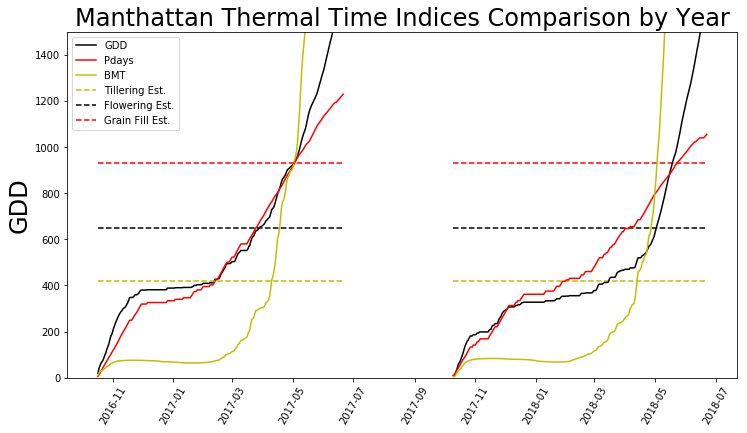

In [43]:
#size plot
plt.figure(figsize=(12,14))


#plot 2017 Data
plt.subplot(2,1,2)
plt.plot(df17.Date,df17.cum_GDD, '-k')
plt.plot(df17.Date,df17.cum_Pdays,'-r')
plt.plot(df17.Date,df17.cum_BMT,'-y')
plt.ylabel('GDD', fontsize =24)
plt.xticks(rotation=60)

#plot stage prediction lines
plt.plot(df17.Date, df17.Tillering, '--y')
plt.plot(df17.Date, df17.Flower, '--k')
plt.plot(df17.Date, df17.GrainFill, '--r')
plt.plot(df18.Date, df18.Tillering, '--y')
#plt.plot(df18.Date, df18.cum_BMT, '--y')
plt.plot(df18.Date, df18.Flower, '--k')
plt.plot(df18.Date, df18.GrainFill, '--r')

#plot 2018 Data
plt.subplot(2,1,2)
plt.plot(df18.Date,df18.cum_GDD, 'k')
plt.plot(df18.Date,df18.cum_Pdays, 'r')
plt.plot(df18.Date,df18.cum_BMT,'-y')
plt.ylabel('GDD', fontsize =24)
plt.xticks(rotation=60)


# edit plot
plt.title('Manthattan Thermal Time Indices Comparison by Year', size=24)

plt.legend(['GDD', 'Pdays','BMT','Tillering Est.','Flowering Est.', 'Grain Fill Est.'], loc=2)
axes = plt.gca()
axes.set_ylim([0,1500])

plt.show()

**The final remaining cells are desinged to merge the thermal time indices to UAV reflectance data based on date of collection**

In [44]:
dirname = '/Users/bevers/Desktop/Coding/Thermal_Time_Indices/Data/'
filename_18 ='2018_MCP_NDVI.csv'

In [45]:
UAV18 = pd.read_csv(dirname + filename_18)
#UAV18['Date'] =  pd.to_datetime(UAV18['Date'],format='%Y-%m-%d') # formats 'Date' coulmn to correct datetime format
UAV18['Date'] = pd.to_datetime(UAV18.Date)
UAV18.head(5)

,Plot_ID,KC,KR,Date,NDVI,Column,Range,Merge_id
0,18MP_0,1,1,2018-05-22,0.719,1,1,C1_R1
1,18MP_0,1,1,2018-06-06,0.259,1,1,C1_R1
2,18MP_0,1,2,2018-05-22,0.717,1,2,C1_R2
3,18MP_0,1,2,2018-06-06,0.255,1,2,C1_R2
4,18MP_0,1,3,2018-05-22,0.717,1,3,C1_R3


<a name="Update__output"></a>
<span style="color:red">**This is my final road block. I can get the UAV data and the thermal time indices to merge. However, I want to be able to merge even if the dates are not exact.**<span> 

In [47]:
UAV18['UAV_Date'] = pd.to_datetime(UAV18.Date)
df18['Date'] = pd.to_datetime(df18.Date)

finaldf18 = pd.merge(UAV18,df18, on='Date',how='inner')
finaldf18['Days_Diff']= finaldf18.UAV_Date-finaldf18.Date


In [48]:
finaldf18 = pd.merge(df18, UAV18, on=['Date'], how='inner')
finaldf18 =finaldf18[['Plot_ID','Range', 'Column', 'Date','UAV_Date','STATION','NDVI', 'Tmax','Tmin','cum_GDD','cum_Pdays','cum_BMT']] #selects columns needed
finaldf18.head(5)

,Plot_ID,Range,Column,Date,UAV_Date,STATION,NDVI,Tmax,Tmin,cum_GDD,cum_Pdays,cum_BMT
0,18MP_0,1,1,2018-05-22,2018-05-22,Manhattan,0.719,27.26,12.37,979.38,924.371597,2388.15652
1,18MP_0,2,1,2018-05-22,2018-05-22,Manhattan,0.717,27.26,12.37,979.38,924.371597,2388.15652
2,18MP_0,3,1,2018-05-22,2018-05-22,Manhattan,0.717,27.26,12.37,979.38,924.371597,2388.15652
3,18MP_0,4,1,2018-05-22,2018-05-22,Manhattan,0.704,27.26,12.37,979.38,924.371597,2388.15652
4,18MP_0,5,1,2018-05-22,2018-05-22,Manhattan,0.677,27.26,12.37,979.38,924.371597,2388.15652
